## LIBRERIAS y CONSTANTES

In [1]:
%%capture
print("block")

In [2]:
print("block")

block


In [3]:
import numpy as np
import pandas as pd
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import json
import plotly.express as px

#Implement training process
from model_trees_algebra import NeoRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class BaoTrainingException(Exception):
    pass

URL = "/media/data/ccarmona/memoria/dataset/"

IS CUDA AVAILABLE: True


## CLEAN DATA

In [4]:
def split_ds(all_data, val_rate, seed):
    """
    Used  to keep a balance of sets with respect to runtime of queries. 
    test_rate is a rate of the total,
    val_rate is a rate of the (total - test_rate)
    :param all_data: Pandas dataframe with data
    :param val_rate: Rate of the (total - test_rate)
    :param seed: For replication of results, this fixes the seed of split method. 
    :return: 
    """
    ranges = {}
    ranges['1_2'] = all_data[(all_data["time"] > 0)    & (all_data["time"] <= 2)]
    ranges['2_3'] = all_data[(all_data["time"] > 2)    & (all_data["time"] <= 3)]
    ranges['3_4'] = all_data[(all_data["time"] > 3)    & (all_data["time"] <= 4)]
    ranges['4_5'] = all_data[(all_data["time"] > 4)    & (all_data["time"] <= 5)]
    ranges['5_8'] = all_data[(all_data["time"] > 5)    & (all_data["time"] <= 8)]
    ranges['8_10'] = all_data[(all_data["time"] > 8)   & (all_data["time"] <= 10)]
    ranges['10_20'] =   all_data[(all_data["time"] > 10) & (all_data["time"] <= 20)]
    ranges['20_30'] =   all_data[(all_data["time"] > 20) & (all_data["time"] <= 30)]
    ranges['30_40'] =   all_data[(all_data["time"] > 30) & (all_data["time"] <= 40)]
    ranges['40_50'] =   all_data[(all_data["time"] > 40) & (all_data["time"] <= 50)]
    ranges['50_60'] =   all_data[(all_data["time"] > 50) & (all_data["time"] <= 60)]
    ranges['60_80'] =   all_data[(all_data["time"] > 60) & (all_data["time"] <= 80)]
    ranges['80_100'] =  all_data[(all_data["time"] > 80) & (all_data["time"] <= 100)]
    ranges['100_150'] = all_data[(all_data["time"] > 100) & (all_data["time"] <= 150)]
    ranges['150_200'] = all_data[(all_data["time"] > 150) & (all_data["time"] <= 200)]
    ranges['200_250'] = all_data[(all_data["time"] > 200) & (all_data["time"] <= 250)]
    ranges['250_last'] = all_data[(all_data["time"] > 250)]
    train_data = []
    val_data = []
    for rang in ranges.values():
        if rang.shape[0] >= 3:
            X_train, X_val = train_test_split(
                rang, test_size=val_rate, shuffle=True,random_state=seed)

            train_data.append(X_train)
            val_data.append(X_val)
    train_data_list = pd.concat(train_data)
    val_data_list = pd.concat(val_data)
    print("Shapes : Train: {} Val: {}".format(train_data_list.shape, val_data_list.shape))
    return train_data_list, val_data_list

data_train_val_raw = pd.read_csv(URL + "ds_trainval_pred_filtered.csv", delimiter="ᶶ", engine='python')
ds_test_raw = pd.read_csv(URL + "ds_test_pred_filtered.csv", delimiter="ᶶ", engine='python')

data_train_val_prev = data_train_val_raw[data_train_val_raw['time'] <=65]
ds_test_prev = ds_test_raw[ds_test_raw['time'] <=65]

print("Shape: train_val data" , data_train_val_prev.shape)
def clear_error_tuples(x):
    try:
        #if x == '["VAR_URI_LITERALᶲhttp://www.wikidata.org/prop/direct/P2529"]':
         #   print(x)
        #print(type(x))
        json.loads(x)
        return True
    except:
        print("Error in data ignored!", x)
        return False

#Split Dataset
ds_train_prev, ds_val_prev = split_ds(data_train_val_prev, 0.2,seed=None)
#Remove bad rows
ds_train  = ds_train_prev[ds_train_prev['trees'].apply(lambda x: clear_error_tuples(x))]
ds_val  = ds_val_prev[ds_val_prev['trees'].apply(lambda x: clear_error_tuples(x))]
ds_test  = ds_test_prev[ds_test_prev['trees'].apply(lambda x: clear_error_tuples(x))]


x = ds_test_prev['trees'][20]
print(x)
x = json.loads(x)
print(x)

Shape: train_val data (21703, 84)
Shapes : Train: (17357, 84) Val: (4346, 84)
Error in data ignored! [datasetnames ?var1]
Error in data ignored! [reduced   ["VAR_VAR_VARᶲNONE"]]
Error in data ignored! [reduced   ["VAR_VAR_VARᶲNONE"]]
Error in data ignored! [reduced   ["VAR_VAR_VARᶲNONE"]]
Error in data ignored! [reduced   ["VAR_VAR_VARᶲNONE"]]
Error in data ignored! [bgp "VAR_URI_VARᶲhttp://www.wikidata.org/prop/direct/P685"]
[ "JOINᶲhttp://www.wikidata.org/prop/direct/P31ᶲhttp://schema.org/description" ,   [ "VAR_URI_URIᶲhttp://www.wikidata.org/prop/direct/P31" ] ,   [ "VAR_URI_LITERALᶲhttp://schema.org/description" ] ] 
['JOINᶲhttp://www.wikidata.org/prop/direct/P31ᶲhttp://schema.org/description', ['VAR_URI_URIᶲhttp://www.wikidata.org/prop/direct/P31'], ['VAR_URI_LITERALᶲhttp://schema.org/description']]


In [5]:
print("---------SHAPES-----------")
print("----------RAW-----------")
print(f'shape data_train_val_raw: {data_train_val_raw.shape}')
print(f'shape ds_test_raw: {ds_test_raw.shape}')
print("----------PREV----------")
print(f'shape ds_train_prev: {ds_train_prev.shape}')
print(f'shape ds_val_prev: {ds_val_prev.shape}')
print(f'shape ds_test_prev: {ds_test_prev.shape}')
print("----------CLEAN----------")
print(f'shape ds_train: {ds_train.shape}')
print(f'shape ds_val: {ds_val.shape}')
print(f'shape ds_test: {ds_test.shape}')
print("-----------------------")

---------SHAPES-----------
----------RAW-----------
shape data_train_val_raw: (25805, 84)
shape ds_test_raw: (3528, 84)
----------PREV----------
shape ds_train_prev: (17357, 84)
shape ds_val_prev: (4346, 84)
shape ds_test_prev: (2963, 84)
----------CLEAN----------
shape ds_train: (17352, 84)
shape ds_val: (4345, 84)
shape ds_test: (2963, 84)
-----------------------


In [6]:
def getpredictions_info(x_val_tree, x_val_query, y_val):
    """
    Get statistics by a set of data. Need the previous trained model(availablre  form reg object).
    :param x_val_tree: Plan level features.
    :param x_val_query: Query level features.
    :param y_val: Real execution time
    :return: Dict with predictions and metrics (mae, rmse, mse)
    """
    Xt, Xq, Yv = reg.json_loads(x_val_tree, x_val_query.values, y_val)
    Xt = [reg.fix_tree(x) for x in Xt]
    Xt = reg.tree_transform.transform(Xt)

    pairs_val = list(zip(list(zip(Xt, Xq)), Yv))
    dataset_val = DataLoader(pairs_val, batch_size=64, num_workers=0, shuffle=False, collate_fn=reg.collate_with_card)
    results_val = reg.predict_best(dataset_val)
    y_pred_val, y_real_val = zip(*results_val)
    mseval = mean_squared_error(y_real_val, y_pred_val)
    maeval = mean_absolute_error(y_real_val, y_pred_val)
    rmseval = np.sqrt(mseval)
    return {"pred": y_pred_val, "real" : y_real_val, "mse": mseval, "mae": maeval, "rmse": rmseval, "history": reg.history}

def getmax(x):
    lista=  list(x.values())
    maximo = 0
    for el in lista:
        if (maximo < float(el)):
            maximo = float(el)
    return maximo

def pred2index_dict(x, pred_to_index, maxcardinality):
    """
    get histogram from cardinality features. the values is normalized using the max cardinality of predicate in dataset.
    :param x: Tree data from x row sample.
    :param pred_to_index: dict with predicates and their index.
    :param maxcardinality: Max cardiniality in the dataset.
    :return: dictionary with feature json_cardinality.
    """
    resp = {}
    x = json.loads(x)
    for el in x.keys():
        if el in pred_to_index:
            resp[pred_to_index[el]] = float(x[el])/maxcardinality
    return resp

def prepare_query_level_data(x_train_query, x_val_query, x_test_query):
    """ Apply StandardScaller to columns except for json_cardinality that need other proccess"""
    maxcardinality =  x_train_query['json_cardinality'].apply(lambda x: json.loads(x)).apply(lambda x: getmax(x)).max()
    #Scale x_query data.
    xqtrain = x_train_query.drop(columns=['json_cardinality'])
    xqval   = x_val_query.drop(columns=['json_cardinality'])
    xqtest   = x_test_query.drop(columns=['json_cardinality'])

    scalerx = StandardScaler()
    x_train_scaled = scalerx.fit_transform(xqtrain)
    x_val_scaled = scalerx.transform(xqval)
    x_test_scaled = scalerx.transform(xqtest)

    x_train_query =pd.concat([pd.DataFrame(x_train_scaled, index=xqtrain.index, columns=xqtrain.columns),x_train_query[['json_cardinality']]], axis=1)
    x_val_query =  pd.concat([pd.DataFrame(x_val_scaled,   index=xqval.index, columns=xqval.columns),x_val_query[['json_cardinality']]], axis=1)
    x_test_query =  pd.concat([pd.DataFrame(x_test_scaled,   index=xqtest.index, columns=xqtest.columns),x_test_query[['json_cardinality']]], axis=1)

    x_train_query['json_cardinality'] = x_train_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(),maxcardinality))
    x_val_query['json_cardinality'] = x_val_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))
    x_test_query['json_cardinality'] = x_test_query['json_cardinality'].apply(lambda x: pred2index_dict(x, reg.get_pred(), maxcardinality))

    return x_train_query, x_val_query, x_test_query


### TreeConv Neural Net

In [7]:
# Columns to use.
list_columns = ['assign', 'bgp', 'distinct', 'extend', 'filter', 'graph', 'group',
'join', 'leftjoin','minus', 'multi', 'notoneof', 'order', 'path*',  'project', 'reduced',
'sequence', 'slice', 'tolist', 'top','treesize', 'triple', 'union' ,
'path+', 'path?', 'pathN*', 'pathN+', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4',
'pcs5', 'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11','pcs12', 'pcs13',
'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21', 'pcs22', 'pcs23', 'pcs24',
                'filter_bound', 'filter_contains', 'filter_eq', 'filter_exists',
       'filter_ge', 'filter_gt', 'filter_isBlank', 'filter_isIRI',
       'filter_isLiteral', 'filter_lang', 'filter_langMatches', 'filter_le',
       'filter_lt', 'filter_ne', 'filter_not', 'filter_notexists', 'filter_or',
       'filter_regex', 'filter_sameTerm', 'filter_str', 'filter_strends',
       'filter_strstarts', 'filter_subtract', 'has_slice', 'max_slice_limit', 'max_slice_start','json_cardinality']
folds_execution = {}

print("Size Train: {}, Val {}".format(ds_train.shape[0], ds_val.shape[0]))


Size Train: 17352, Val 4345


In [8]:
# get query level data
x_train_query = ds_train[list_columns]
x_val_query   = ds_val[list_columns]

# get plan level data
x_train_tree = ds_train['trees'].values
x_val_tree = ds_val['trees'].values

y_train = ds_train['time'].values
y_val = ds_val['time'].values

x_test_tree = ds_test['trees'].values
y_test = ds_test['time'].values
x_test_query   = ds_test[list_columns]

In [9]:
print("---------SHAPES-----------")
print("----------CLEAN-----------")
print(f'shape ds_train: {ds_train.shape}')
print(f'shape ds_val  : {ds_val.shape}')
print(f'shape ds_test : {ds_test.shape}')
print("")
print("-----TRAIN AND VAL DATA-----")
print("----------x_query_data----------")
print(f'shape x_val_query  : {x_val_query.shape}')
print(f'shape x_train_query: {x_train_query.shape}')
print("----------x_plan_level_data----------")
print(f'shape x_val_tree  : {x_val_tree.shape}')
print(f'shape x_train_tree: {x_train_tree.shape}')
print("----------y_data------------")
print(f'shape y_val  : {y_val.shape}')
print(f'shape y_train: {y_train.shape}')
print("")
print("----------TEST DATA----------")
print(f'shape x_test_tree : {x_test_tree.shape}')
print(f'shape x_test_query: {x_test_query.shape}')
print(f'shape y_test      : {y_test.shape}')
print("-----------------------")


---------SHAPES-----------
----------CLEAN-----------
shape ds_train: (17352, 84)
shape ds_val  : (4345, 84)
shape ds_test : (2963, 84)

-----TRAIN AND VAL DATA-----
----------x_query_data----------
shape x_val_query  : (4345, 79)
shape x_train_query: (17352, 79)
----------x_plan_level_data----------
shape x_val_tree  : (4345,)
shape x_train_tree: (17352,)
----------y_data------------
shape y_val  : (4345,)
shape y_train: (17352,)

----------TEST DATA----------
shape x_test_tree : (2963,)
shape x_test_query: (2963, 79)
shape y_test      : (2963,)
-----------------------


In [10]:
maxcardinality =  x_train_query['json_cardinality'].apply(lambda x: json.loads(x)).apply(lambda x: getmax(x)).max()
maxcardinality

1403214524.0

## NeoRegression
Esta en model_trees_algebra.py

In [11]:
aec_dir = ''

verbose=True
reg = NeoRegression(
     aec={'train_aec': False, 'use_aec': True,'aec_file': '', 'aec_epochs': 200},
     epochs=400,
     maxcardinality=maxcardinality,
     in_channels_neo_net=512,
     tree_units=[512, 256, 128],
     tree_units_dense=[64, 32],
     early_stop_patience=10,
     early_stop_initial_patience=180,
     tree_activation_tree=nn.LeakyReLU,
     tree_activation_dense=nn.ReLU,
    optimizer={'optimizer': "Adam",'args':{"lr":0.00015}},
    figimage_size=(18,18),
    start_history_from_epoch=3
)


NeoRegression, __init__ method active
Model optimizer: Adam lr: 0.00015
SPARQLTreeFeaturizer, __init__ method active


In [12]:
from IPython.utils import io

In [13]:
#Fit the transformer tree data
    ### Esto en el fondo mapea tanto  JOINS ,LEFT JOINS, los tipos de triple como VAR_URI_VAR, VAR_VAR_LITERAL ETC.. 
    ### ASI COMO TAMBIEN MAPEA LOS PREDICADOS a un indice
with io.capture_output() as captured:
    reg.fit_transform_tree_data(ds_train, ds_val, ds_test)
print("Trees tranformed!!!")


Trees tranformed!!!


In [14]:
with io.capture_output() as captured:
    x_train_query, x_val_query, x_test_query =  prepare_query_level_data(x_train_query, x_val_query, x_test_query)
print("END PREPARE QUERY LEVEL DATA")

END PREPARE QUERY LEVEL DATA


NeoRegression, fit method active
X_train loaded
X_val loaded
Transforming Trees: se pasan a una tupla donde cada número representa lo que se obtiene en reg.fit_transform_tree_data(ds_train, ds_val, ds_test)
determine the initial number of channels, io_dim 1872
Initial input channels of tree model: None
Activation function in treeConv layers: <class 'torch.nn.modules.activation.LeakyReLU'>
Activation function in tree dense output layers: <class 'torch.nn.modules.activation.ReLU'>
[BinaryTreeConvWithQData(
  (weights): Conv1d(2112, 512, kernel_size=(3,), stride=(3,))
), TreeLayerNorm(), TreeActivation(
  (activation): LeakyReLU(negative_slope=0.01)
), BinaryTreeConv(
  (weights): Conv1d(512, 256, kernel_size=(3,), stride=(3,))
), TreeLayerNorm(), TreeActivation(
  (activation): LeakyReLU(negative_slope=0.01)
), BinaryTreeConv(
  (weights): Conv1d(256, 128, kernel_size=(3,), stride=(3,))
), TreeLayerNorm(), TreeActivation(
  (activation): LeakyReLU(negative_slope=0.01)
), DynamicPooling()

2021-11-09 15:29:14.915178 Epoch 23, Training loss 2.6385186026682498e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 23,	TRAIN_LOSS: 22.239740029529653	_TRAIN_RMSE: 4.715902885930715,	VAL_LOSS: 34.010207367289794,	VAL_RMSE: 5.831827103686271
Initial patience 157
2021-11-09 15:29:35.532534 Epoch 24, Training loss 2.6657516409173303e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 24,	TRAIN_LOSS: 22.226738698100537	_TRAIN_RMSE: 4.714524228180458,	VAL_LOSS: 33.15953373553823,	VAL_RMSE: 5.758431534327575
Initial patience 156
NeoRegression, scatter_plot_history method active
2021-11-09 15:30:00.683261 Epoch 25, Training loss 2.589235089601319e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 25,	TRAIN_LOSS: 21.951760698210673	_TRAIN_RMSE: 4.685270610990434,	VAL_LOSS: 40.5281947304287,	VAL_RMSE: 6.366175832509553
Initial patience 155
2021-11-09 15:30:21.291173 Epoch 26, Training loss 2.6518412643693513e-05
NeoRegr

NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 50,	TRAIN_LOSS: 27.117737881923507	_TRAIN_RMSE: 5.2074694316840215,	VAL_LOSS: 31.479940442048058,	VAL_RMSE: 5.61069874811044
Initial patience 130
2021-11-09 15:39:22.322702 Epoch 51, Training loss 2.3201642007989245e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 51,	TRAIN_LOSS: 18.93774849012515	_TRAIN_RMSE: 4.351752347058039,	VAL_LOSS: 31.710823319857163,	VAL_RMSE: 5.631236393533587
Initial patience 129
2021-11-09 15:39:42.779356 Epoch 52, Training loss 2.3456011327199785e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 52,	TRAIN_LOSS: 19.22405027488292	_TRAIN_RMSE: 4.384523950770816,	VAL_LOSS: 32.05951587634893,	VAL_RMSE: 5.6621123157659925
Initial patience 128
NeoRegression, scatter_plot_history method active
2021-11-09 15:40:07.659426 Epoch 53, Training loss 2.343591440923686e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 53,	TRAIN

SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 77,	TRAIN_LOSS: 18.22711034891397	_TRAIN_RMSE: 4.2693220010809645,	VAL_LOSS: 29.74343798465871,	VAL_RMSE: 5.4537544851834605
Initial patience 103
2021-11-09 15:49:09.586250 Epoch 78, Training loss 2.2232778917048086e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 78,	TRAIN_LOSS: 18.560432746857025	_TRAIN_RMSE: 4.308182069836072,	VAL_LOSS: 29.48854475419311,	VAL_RMSE: 5.430335602353975
Initial patience 102
2021-11-09 15:49:30.111783 Epoch 79, Training loss 2.224795596571013e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 79,	TRAIN_LOSS: 17.760281742774293	_TRAIN_RMSE: 4.214294928309395,	VAL_LOSS: 31.96130093915679,	VAL_RMSE: 5.653432668667487
Initial patience 101
2021-11-09 15:49:50.694707 Epoch 80, Training loss 2.2059487465038034e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 80,	TRAIN_LOSS: 18.068173285020382	_TRAIN_RMSE: 4.250667392894954,	VAL_LOSS: 30.31459159958923,	

2021-11-09 15:58:55.795453 Epoch 105, Training loss 2.1890722551046673e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 105,	TRAIN_LOSS: 17.491134239391894	_TRAIN_RMSE: 4.182240337354119,	VAL_LOSS: 29.427442904158557,	VAL_RMSE: 5.424706711349339
Initial patience 75
2021-11-09 15:59:16.254540 Epoch 106, Training loss 2.1688334968797898e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 106,	TRAIN_LOSS: 17.364470419449418	_TRAIN_RMSE: 4.167069764168752,	VAL_LOSS: 33.09425474020627,	VAL_RMSE: 5.752760619059885
Initial patience 74
2021-11-09 15:59:35.885334 Epoch 107, Training loss 2.258296266420742e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 107,	TRAIN_LOSS: 18.47865962030465	_TRAIN_RMSE: 4.29868114894611,	VAL_LOSS: 29.41770010147602,	VAL_RMSE: 5.423808634297123
Initial patience 73
2021-11-09 15:59:55.993710 Epoch 108, Training loss 2.157435307793481e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOO

NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 132,	TRAIN_LOSS: 17.740046167072556	_TRAIN_RMSE: 4.211893418294503,	VAL_LOSS: 28.44946189224702,	VAL_RMSE: 5.333803698323273
Initial patience 48
NeoRegression, scatter_plot_history method active
2021-11-09 16:09:03.779988 Epoch 133, Training loss 2.0993348689884834e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 133,	TRAIN_LOSS: 16.822704350795778	_TRAIN_RMSE: 4.101549018455805,	VAL_LOSS: 29.516617862668593,	VAL_RMSE: 5.432919828477924
Initial patience 47
2021-11-09 16:09:24.424930 Epoch 134, Training loss 2.1046796348007297e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 134,	TRAIN_LOSS: 16.866236559085795	_TRAIN_RMSE: 4.106852390710651,	VAL_LOSS: 29.40961386577635,	VAL_RMSE: 5.423063144181188
Initial patience 46
2021-11-09 16:09:45.039371 Epoch 135, Training loss 2.105294651581024e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 135,	T

NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 159,	TRAIN_LOSS: 17.168112661193067	_TRAIN_RMSE: 4.143442127168312,	VAL_LOSS: 30.65346390613432,	VAL_RMSE: 5.536557044421589
Initial patience 21
2021-11-09 16:18:46.504305 Epoch 160, Training loss 2.0988543867926612e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 160,	TRAIN_LOSS: 17.153328591682676	_TRAIN_RMSE: 4.141657710589164,	VAL_LOSS: 29.299983983494233,	VAL_RMSE: 5.412945961627017
Initial patience 20
NeoRegression, scatter_plot_history method active
2021-11-09 16:19:11.528529 Epoch 161, Training loss 2.1095439732936723e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 161,	TRAIN_LOSS: 17.21444621598415	_TRAIN_RMSE: 4.149029551110012,	VAL_LOSS: 28.54756529209975,	VAL_RMSE: 5.342992166576678
Initial patience 19
2021-11-09 16:19:32.243132 Epoch 162, Training loss 2.116490412795098e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 162,	TR

2021-11-09 16:29:42.226950 Epoch 190, Training loss 2.0657282056348915e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 190,	TRAIN_LOSS: 16.64817627022578	_TRAIN_RMSE: 4.080217674368094,	VAL_LOSS: 28.920345827429628,	VAL_RMSE: 5.377764017454617
EarlyStopping counter: 1 out of 10
2021-11-09 16:30:02.856289 Epoch 191, Training loss 2.1108890501844483e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 191,	TRAIN_LOSS: 16.571615447641037	_TRAIN_RMSE: 4.070824909971078,	VAL_LOSS: 29.23018677378179,	VAL_RMSE: 5.40649486948631
EarlyStopping counter: 2 out of 10
2021-11-09 16:30:23.299251 Epoch 192, Training loss 2.0873906893048808e-05
NeoRegression, predict method active
SALIMOOOOOOOOOOOOOOOOOO
==> Epoch 192,	TRAIN_LOSS: 16.471364532290465	_TRAIN_RMSE: 4.05849288927435,	VAL_LOSS: 28.619401889316695,	VAL_RMSE: 5.349710449109998
EarlyStopping counter: 3 out of 10
NeoRegression, scatter_plot_history method active
2021-11-09 16:30:47.550644 Epoch 

<Figure size 432x288 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

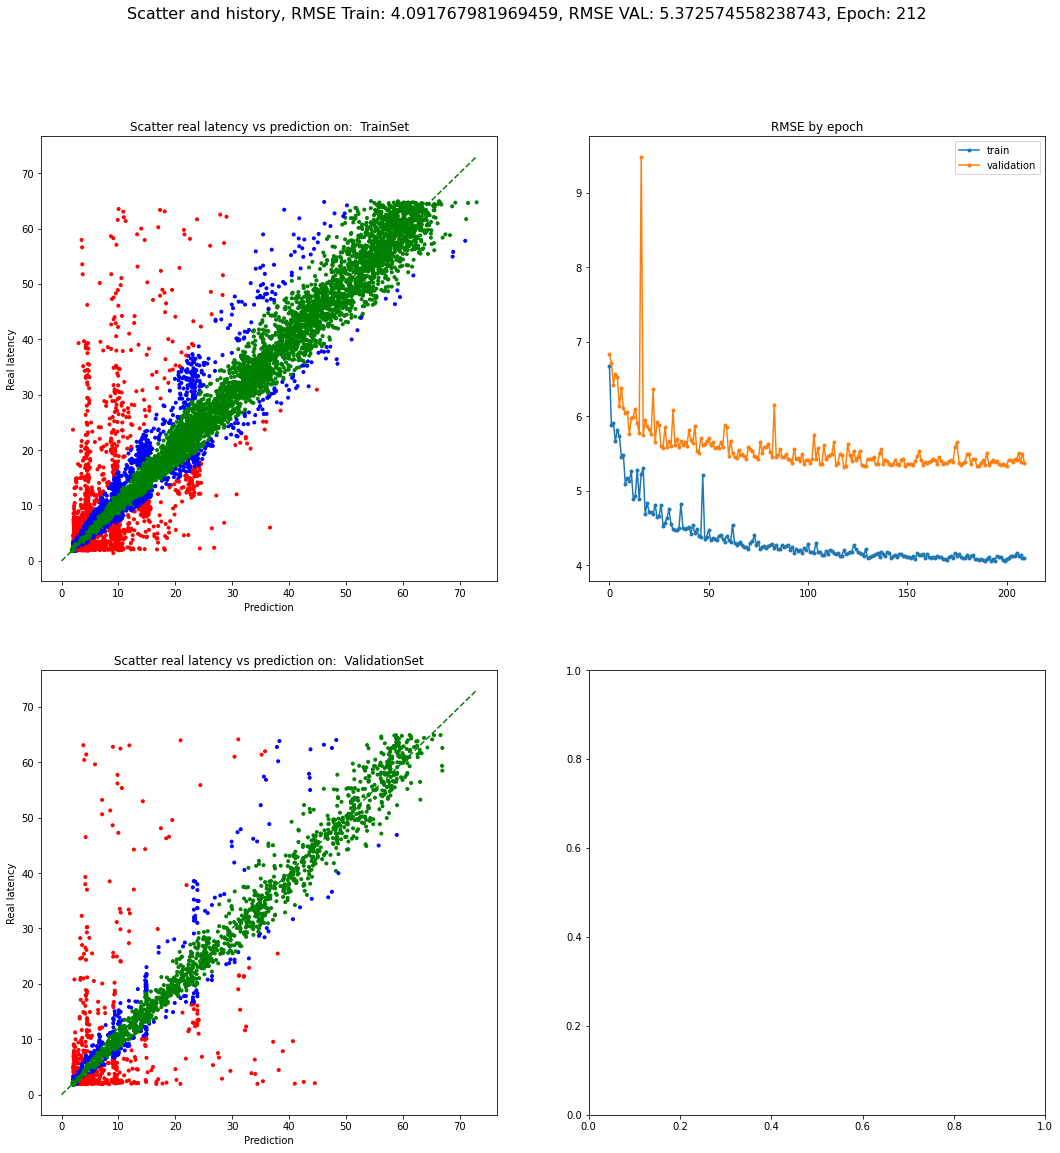

In [15]:

#Fit model
reg.fit(x_train_tree, x_train_query.values, y_train, x_val_tree, x_val_query.values, y_val)
print("EOOOOOOOOO")


In [ ]:
#Save best model
import torch
torch.save(reg.best_model.state_dict(), "./best_model.pt")
#Save stats in val set
file_to_store = open("./execution_model_stats.pickle", "wb")
pickle.dump(getpredictions_info(x_val_tree, x_val_query, y_val), file_to_store)
file_to_store.close()

In [ ]:

val_stats = getpredictions_info(x_val_tree, x_val_query, y_val)

In [ ]:
ds_val['y_pred'] = val_stats['pred']

In [ ]:

test_stats = getpredictions_info(x_test_tree, x_test_query, y_test)

In [ ]:
ds_test['y_realcheck'] = test_stats['real']


In [ ]:
def tag_points(x):
    """Add quality tags of predictions. Used to plot with plotly"""
    difference = x['time'] - x['y_pred'][0]
    abs_diff = np.abs(difference)
    x['y_pred'] = x['y_pred'][0]
    x['query2'] = x['query'].replace(" . ", ' . <br>').replace(" FILTER", '<br> FILTER').replace(" { ", ' { <br>').replace(" } ", ' <br> }').replace(" ; ", ' ; <br>') 
    p20 = x['time'] * 0.2
    p40 = x['time'] * 0.4
    if abs_diff < p20:
        x['color'] = "good prediction"
    elif abs_diff < p40:
        x['color'] = "aceptable prediction"
    else:
        x['color'] = "bad prediction"
    return x

In [ ]:
other = ds_test.apply(lambda x: tag_points(x), axis=1)

In [ ]:
other.to_pickle("./predictions_test.pickle")

In [ ]:
otherval = ds_val.apply(lambda x: tag_points(x), axis=1)

In [ ]:
otherval.to_pickle("./predictions_val.pickle")

In [ ]:
fig = px.scatter(otherval[['id','query','query2','time','y_pred','color']], x="y_pred", y="time", color="color", hover_data=['id', 'query2'])
fig.update_layout(height=800, width=1000, title_text="Predictions on Val Set")
fig.show()

In [ ]:
fig = px.scatter(other[['id','query','query2','time','y_pred','color']], x="y_pred", y="time", color="color", hover_data=['id', 'query2'])
fig.update_layout(height=800, width=1000, title_text="Predictions on Test Set")
fig.show()